from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
!pip install lightgbm
from lightgbm import LGBMClassifier
!pip install fasttext gensim scikit-learn
import pandas as pd
import numpy as np
import re
import time
import fasttext
from tqdm import tqdm
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import LSTM  # Import LSTM layer
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight # Import the compute_class_weight function






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313472 sha256=e4f7d94762c4d57d513e73f7bced97a924b5d6e71324bd1025efac20e3c6c072
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
# Step 1: Load and preprocess the dataset
file_path = "/content/spam_Emails_data.csv"
data = pd.read_csv(file_path)
# Total number of emails in the original dataset
total_emails = len(data)
print(f"Total number of emails in the dataset: {total_emails}")

data = data.dropna(subset=['text'])

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    text = text.lower()
    return text

data['cleaned_text'] = data['text'].astype(str).apply(preprocess_text)
data = data[data['cleaned_text'].str.strip() != ""]
data['tokenized_text'] = data['cleaned_text'].apply(lambda x: x.split())
# Number of emails after preprocessing (removing empty emails)
preprocessed_emails = len(data[data['cleaned_text'].str.strip() != ""])
print(f"Number of emails after preprocessing: {preprocessed_emails}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/spam_Emails_data.csv'

Training FastText model...
FastText training completed in 2210.93 seconds.


100%|██████████| 193752/193752 [01:59<00:00, 1617.62it/s]


<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(20,)
Reducing dimensionality using PCA...
Generating plot...
0
[array([-0.2325906 , -7.603956  , -1.1355247 , -3.631539  ,  2.4909415 ,
        0.37373543, -2.2274606 , -3.874631  , -3.094216  ,  2.9967206 ,
        2.1467164 ,  1.7054149 ,  6.874098  , -0.9463549 ,  0.8614242 ,
       -4.4092073 , -2.393143  ,  2.3799875 ,  1.5591097 ,  0.8740757 ],
      dtype=float32)]


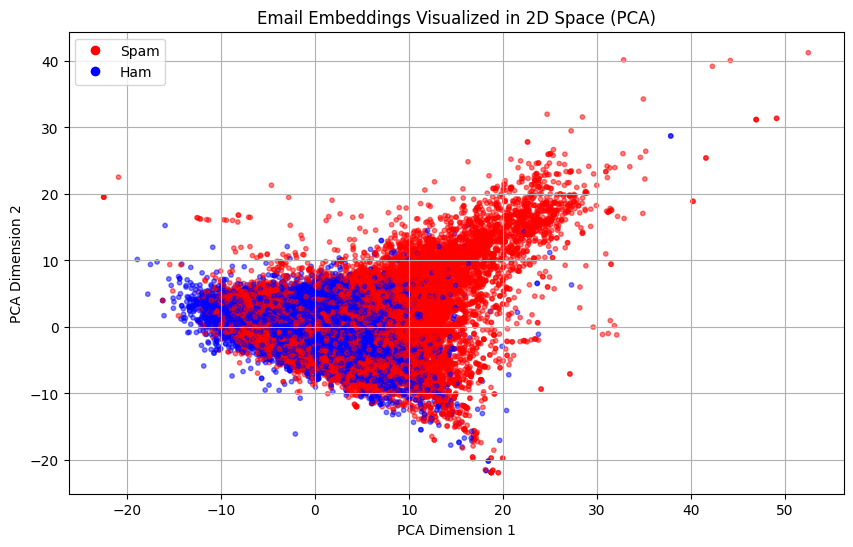

In [ ]:

#  step 2 Train FastText Model
corpus = data['tokenized_text'].tolist()
print("Training FastText model...")
start_time = time.time()

fasttext_model = FastText(
    sentences=corpus,
    vector_size=20,  # Smaller for efficiency
    window=5,
    min_count=2,
    sg=0,  # CBOW (fast training)
    workers=4,  # Adjust based on CPU cores
    epochs=5
)

end_time = time.time()
print(f"FastText training completed in {end_time - start_time:.2f} seconds.")

#  Generate Embeddings
def get_email_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Apply embedding function to all emails
tqdm.pandas()
data['embedding'] = data['tokenized_text'].progress_apply(lambda x: get_email_embedding(x, fasttext_model))

# Convert embeddings to NumPy array
X = np.vstack(data['embedding'].values)  # Shape: (190K, 20)
print(type(data['embedding']))  # Ye Series honi chahiye
print(type(data['embedding'].iloc[0]))  # Ye numpy.ndarray hona chahiye
print(data['embedding'].iloc[0].shape)  # Ye (20,) hona chahiye


#  Reduce to 2D using PCA
print("Reducing dimensionality using PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # Shape: (190K, 2)

#  Plot Embeddings in 2D Space
print("Generating plot...")
plt.figure(figsize=(10, 6))

# Define colors: Spam (red), Ham (blue)
colors = {'Spam': 'red', 'Ham': 'blue'}
data['color'] = data['label'].map(colors)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['color'], alpha=0.5, s=10)

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("Email Embeddings Visualized in 2D Space (PCA)")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor='red', label='Spam'),
                    plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor='blue', label='Ham')])
print(data['embedding'].isnull().sum())  # Ye 0 aana chahiye agar sab pe embeddings hain
print(data['embedding'].sample(1).tolist())  # 5 random embeddings print karega



plt.grid(True)
plt.show()


In [ ]:
# step 3 XG Boost for feature selection
# Load Data (Ensure 'X' contains FastText embeddings & 'data["label"]' contains Spam/Ham labels)
y = data['label'].map({'Ham': 0, 'Spam': 1})

# Print Initial Data Info
print(f"Total Emails: {X.shape[0]}")
print(f"Initial Features: {X.shape[1]}")
#  Train XGBoost Model for Feature Selection on the Complete Dataset
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X, y)

# Remove the re-initialization of xgb_model:
# xgb_model = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, eval_metric='logloss')

# Apply Feature Selection to the Entire Dataset
selector_xgb = SelectFromModel(xgb_model, prefit=True)
X_selected_xgb = selector_xgb.transform(X)


# Print Features After Selection
print(f"Features Selected by XGBoost: {X_selected_xgb.shape[1]} out of {X.shape[1]}")

#  Split the Dataset After Feature Selection (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X_selected_xgb, y, test_size=0.2, random_state=42)

# Print Final Data Shapes
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

#  Save Selected Features and Split Data for Future Use
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

print("Feature selection and train-test split complete. Data saved for ML/DL models.")


Total Emails: 193752
Initial Features: 20


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Features Selected by XGBoost: 5 out of 20
Training Data: (155001, 5), Testing Data: (38751, 5)
Feature selection and train-test split complete. Data saved for ML/DL models.


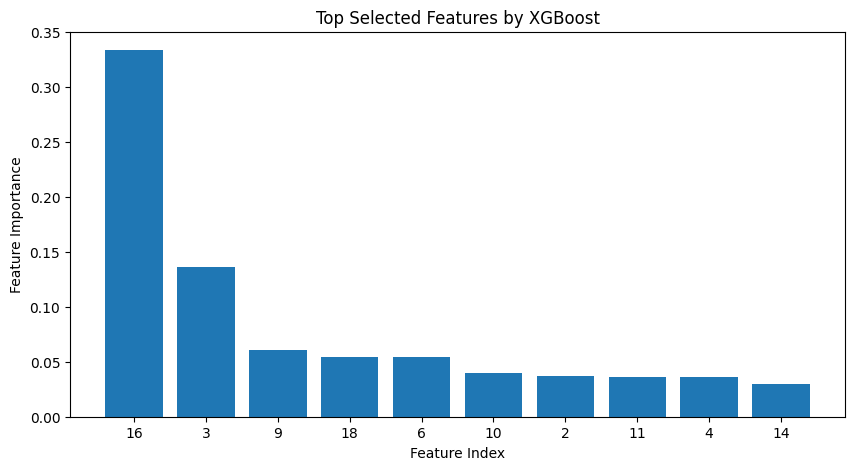

In [ ]:
# show xg boost result in plot

# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]  # Highest to lowest

plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_idx[:10])), feature_importance[sorted_idx[:10]], align="center")
plt.xticks(range(len(sorted_idx[:10])), sorted_idx[:10])  # Display feature indices
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Top Selected Features by XGBoost")
plt.show()


In [ ]:
# step 4 Train CNN  model  # Load Preprocessed Dataset (Feature Selected)
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Print Dataset Shapes
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Reshape Data for CNN (Adding 1 Channel Dimension for Conv1D)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Import BatchNormalization and Dropout
from tensorflow.keras.layers import BatchNormalization, Dropout # This line imports the class

# Define CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'), # Add padding='same'
    BatchNormalization(),
    MaxPooling1D(pool_size=2), # Reduce spatial dimension using MaxPooling
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'), # Add padding='same'
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary Classification (Spam/Ham)
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# check Train dataset accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=1)
print(f"Train Accuracy: {train_acc * 100:.2f}%")
# Test dataset accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predict on Test Set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert Probabilities to 0/1


# Predict on Test Set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert Probabilities to 0/1

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Training Data Shape: (155001, 5)
Testing Data Shape: (38751, 5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8805 - loss: 0.2912 - val_accuracy: 0.9006 - val_loss: 0.2430
Epoch 2/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8992 - loss: 0.2511 - val_accuracy: 0.9074 - val_loss: 0.2305
Epoch 3/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9014 - loss: 0.2436 - val_accuracy: 0.9098 - val_loss: 0.2253
Epoch 4/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9050 - loss: 0.2385 - val_accuracy: 0.9101 - val_loss: 0.2242
Epoch 5/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9063 - loss: 0.2336 - val_accuracy: 0.9086 - val_loss: 0.2286
Epoch 6/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9082 - loss: 0.2304 - val_accuracy: 0.9105 - val_loss: 0.2208
Epoch 7/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9078 - loss: 0.2301 - val_accuracy: 0.9123 - val_loss: 0.2209
Epoch 8/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9088 - loss: 0

In [ ]:
# Step 4 Train LSTM model #Load Preprocessed Dataset (Feature Selected)
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Print Dataset Shapes
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Reshape Data for LSTM (Adding Time Step Dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, timesteps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(128),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary Classification (Spam/Ham)
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict on Test Set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert Probabilities to 0/1

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Training Data Shape: (155001, 5)
Testing Data Shape: (38751, 5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - accuracy: 0.8514 - loss: 0.3444 - val_accuracy: 0.9062 - val_loss: 0.2314
Epoch 2/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.8981 - loss: 0.2528 - val_accuracy: 0.9101 - val_loss: 0.2251
Epoch 3/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.9011 - loss: 0.2491 - val_accuracy: 0.9104 - val_loss: 0.2219
Epoch 4/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.9042 - loss: 0.2413 - val_accuracy: 0.9108 - val_loss: 0.2210
Epoch 5/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.9062 - loss: 0.2383 - val_accuracy: 0.9114 - val_loss: 0.2229
Epoch 6/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9062 - loss: 0.2344 - val_accuracy: 0.9103 - val_loss: 0.2221
Epoch 7/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.9071 - loss: 0.2340 - val_accuracy: 0.9126 - val_loss: 0.2158
Epoch 8/10
4844/4844 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.9087 -

In [ ]:
# Train Roberta Model  Load the preprocessed dataset
data = pd.read_csv("/content/spam_Emails_data.csv")  # Replace with your actual dataset path
data['cleaned_text'] = data['text'].astype(str).apply(lambda x: x.lower().strip())

# Assuming X_train_text, X_test_text, y_train, y_test were saved from previous steps
X_train_text = data['cleaned_text'].iloc[np.where(data.index.isin(np.load("y_train.npy")))[0]].values
X_test_text = data['cleaned_text'].iloc[np.where(data.index.isin(np.load("y_test.npy")))[0]].values
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# 2. Define Roberta Model and Tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 3. Custom Dataset Class
class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# 4. Create Datasets and Dataloaders
train_dataset = SpamDataset(X_train_text, y_train, tokenizer)
test_dataset = SpamDataset(X_test_text, y_test, tokenizer)

batch_size = 42
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Training and Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 5  # Adjust as needed
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

# Evaluation
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask).logits
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

        y_preds.extend(predictions)
        y_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_preds)
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1 = f1_score(y_true, y_preds)


print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5/5: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s, loss=0.571]


Accuracy: 50.00%
Precision: 100.00%
Recall: 50.00%
F1 Score: 66.67%


In [ ]:
# Step 3 feaature selection using LightGBM Load Data (Ensure 'X' contains FastText embeddings & 'data["label"]' contains Spam/Ham labels)
y = data['label']

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print Initial Data Info
print(f"🔹 Total Emails: {X.shape[0]}")
print(f"🔹 Initial Features: {X.shape[1]}")

# Train LightGBM Model for Feature Selection
lgbm_model = LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1) # Now LGBMClassifier should be recognized
lgbm_model.fit(X_train, y_train)

# Select Important Features
selector_lgbm = SelectFromModel(lgbm_model, prefit=True)
X_train_selected_lgbm = selector_lgbm.transform(X_train)
X_test_selected_lgbm = selector_lgbm.transform(X_test)

#  Print Features After Selection
print(f" Features Selected by LightGBM: {X_train_selected_lgbm.shape[1]} out of {X.shape[1]}")

# Train LightGBM Model on Selected Features
lgbm_final_model = LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
lgbm_final_model.fit(X_train_selected_lgbm, y_train)

#  Predict & Calculate Accuracy
y_pred_lgbm = lgbm_final_model.predict(X_test_selected_lgbm)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

print(f" Accuracy after LightGBM Feature Selection: {accuracy_lgbm * 100:.2f}%")

🔹 Total Emails: 194325
🔹 Initial Features: 20


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 73612, number of negative: 81848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 155460, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473511 -> initscore=-0.106056
[LightGBM] [Info] Start training from score -0.106056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 73612, number of negative: 81848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 155460, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473511 -> initscore=-0.106056
[LightGBM] [Info] Start training from score -0.106056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🎯 Accuracy after LightGBM Feature Selection: 94.03%


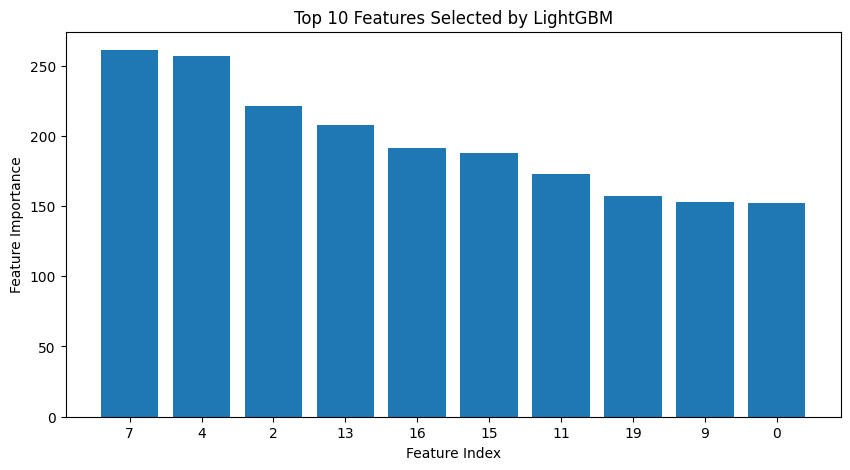

In [ ]:
#step 3 Light GBM feature selection result show in plot
# Get feature importance scores
feature_importance = lgbm_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot Top Features
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_idx[:10])), feature_importance[sorted_idx[:10]], align="center")
plt.xticks(range(len(sorted_idx[:10])), sorted_idx[:10])  # Feature indices
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Top 10 Features Selected by LightGBM")
plt.show()
